In [22]:
import healpy as hp
import numpy as np
import matplotlib as mpl
import matplotlib.image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib import lines
from matplotlib.lines import Line2D
from matplotlib.image import NonUniformImage
import astropy.io
from astropy.io import fits
from astropy import units as u
from astropy.units import cds
from astropy import constants as const
import random
import scipy
import scipy.integrate as integrate
from scipy import stats

In [2]:
def change_coord(m, coord):
    """
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [3]:
#imports all the important maps that we'll use throughout the notebook

a1 = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1)    #reads mean amplitude primary map
nup1 = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1) #reads mean peak freqeuncy primary map
a2 = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2)    #same secondary map
Ad = hp.read_map('COM_CompMap_dust-commander_0256_R2.00 (2).fits', field=0)
Td = hp.read_map('COM_CompMap_dust-commander_0256_R2.00 (2).fits', field=1)
Bd = hp.read_map('COM_CompMap_dust-commander_0256_R2.00 (2).fits', field=2)
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")                #opens map header for frequency template
data = hdu[3].data                                                              #takes array from hdu[3]
nu_sd = np.array([i[0] for i in data])                                          #creates an array of template frequency
f = np.array([i[1] for i in data])                                              #creates an array of spdust2 spectrum
h = hp.read_map('mom0_-90_90_1024.hpx.fits')                                    #reads map of HI column denisty
N_HI = hp.pixelfunc.ud_grade(h, 256)                                              #degrades to NPIX = 256
CNM = hp.read_map('fcnm_hi4pi_hpx.fits')                                       #reads map of CNM fraction
f_CNM = change_coord(CNM, 'CG')
fCNM = hp.ud_grade(f_CNM, 256)                                                   #degrades to NPIX = 256

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [4]:
def I(A1, A2, nu_p1, nu_sd, f, nu):
    ''' Calculate a specific intensity curve for a pixel at either a range or a specific value of nu. First three args
        should be either all floats or all arrays; if arrays, nu should be float, otherwise nu can be either.
        
        Input:  A1: float or array, amplitude from primary map
                A2: float or array, amplitude from secondary map
                nu_p1: float or array, peak frequency from primary map
                nu_sd: array, template frequency
                f: array, template frequency 
                nu: float or array, range of frequencies over which to evaluate the function
        
        Return: array of shape [1,n] (if first three args are floats); 
                  --> values of specific intensity in MJy/sr for each of the n discrete values of nu
                array of shape [n,1] (if first three args are arrays);
                  --> values of specific intensity in MJy/sr at a given nu for each pixel of a map
    '''
    nu_p0 = 30. 
    nu_p2 = 33.35 #sets frequency peak for all secondary pixels
    nu_01 = 22.8 #sets reference freq for primary pixels
    nu_02 = 41.0 #sets reference freq for secondary pixels
    nu_1 = nu_01*(nu_p0/nu_p1) #sets the value nu1 for f_sd1
    nu_2 = nu_02*(nu_p0/nu_p2) #same for 2
    nu_fsd1 = nu*(nu_p0/nu_p1)
    nu_fsd2 = nu*(nu_p0/nu_p2)
    
    f_sd1 = np.interp(nu_1, nu_sd, f) #interpolates nu_sd and f to create f_sd1 at nu1
    f_sd2 = np.interp(nu_2, nu_sd, f) #same for 2
    f_nu1 = np.interp(nu_fsd1, nu_sd, f) #same for general nu
    f_nu2 = np.interp(nu_fsd2, nu_sd, f) #same for general nu
    
    I_1 = A1*((nu_01/nu)**2)*(f_nu1/f_sd1) #component from primary 
    I_2 = A2*((nu_02/nu)**2)*(f_nu2/f_sd2) #component from secondary
    m_K1 = I_1*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #adds units to primary
    m_K2 = I_2*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #same for secondary
    m_J1 = m_K1.to(cds.MJy/cds.sr)
    m_J2 = m_K2.to(cds.MJy/cds.sr)
    m_J = m_J1 + m_J2
    return m_J * cds.sr/cds.MJy #gets rid of units for plotting purposes

In [17]:
def I_therm(A_d, B_d, T_d, nu):
    
    gamma = const.h/(const.k_B*T_d)
    gam = gamma.value
    frac1 = nu/(545)
    frac2 = (np.exp(gam*545)-1)/(np.exp(gam*nu)-1)
    Beta = B_d + 1
    
    S_td = A_d*(frac1**Beta)*frac2
    I_td = S_td*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr)
    I_thermdust = I_td.to(cds.MJy/cds.sr)
    
    return I_thermdust * cds.sr/cds.MJy

In [6]:
idx = np.where((np.isfinite(fCNM)) & (fCNM > 0.02))
mask = np.zeros_like(fCNM)
mask[idx] = 1

a1[mask == 0] = 0
a2[mask == 0] = 0
nup1[mask == 0] = 0
fCNM[mask == 0] = 0
N_HI[mask == 0] = 0
Ad[mask == 0] = 0
Td[mask == 0] = 0
Bd[mask == 0] = 0

a1_shortened = a1[idx]
fraction_sky = len(a1_shortened)/len(a1)
print(fraction_sky*100)

20.995457967122398


Text(0, 0.5, 'nu_p1')

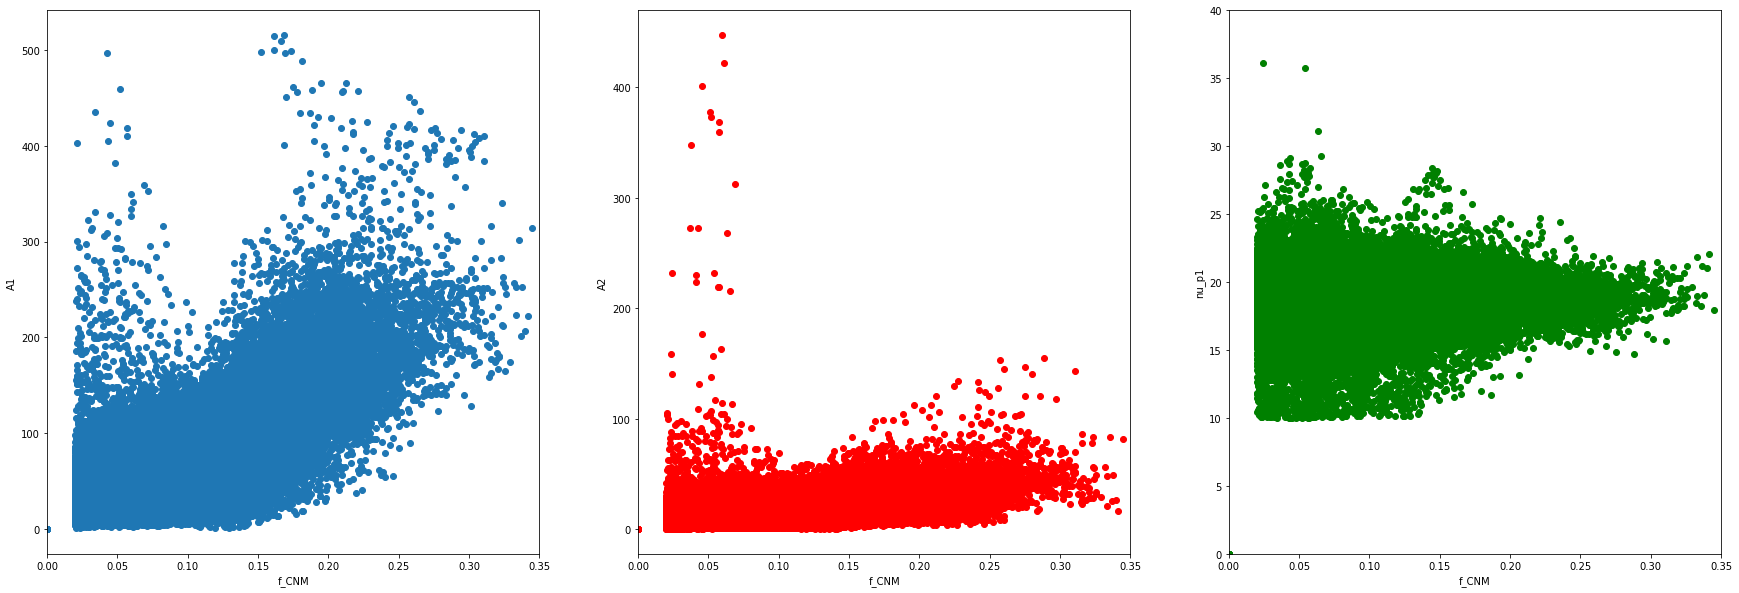

In [7]:
# Looks for general trends in the primary and secondary amplitude vs. f_CNM (blue and red)
# and in peak frequency vs. f_CNM (green)

fig, ax = plt.subplots(1,3, figsize=(30,10))

for i in range(3):
    ax[i].set_xlim(0, .35)

ax[0].scatter(fCNM, a1)
ax[0].set_xlabel("f_CNM")
ax[0].set_ylabel("A1")
plt.ylim(0, 12000)
ax[1].scatter(fCNM, a2, c='r')
plt.ylim(0, 2500)
ax[1].set_xlabel("f_CNM")
ax[1].set_ylabel("A2")
ax[2].scatter(fCNM, nup1, c='g')
plt.ylim(0, 40)
ax[2].set_xlabel("f_CNM")
ax[2].set_ylabel("nu_p1")
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(-1, 2000)

In [13]:
I20 = I(a1, a2, nup1, nu_sd, f, 20)
I30 = I(a1, a2, nup1, nu_sd, f, 30)

N_CNM = N_HI * fCNM

mapNHI = np.log10(N_HI)
mapNHI[mask == 0] = float('NaN')
mapfCNM = fCNM
mapfCNM[mask == 0] = float('NaN')

def IFN_bins(lo, hi):
    Ibin = I30[(fCNM > lo) & (fCNM <= hi)]
    Fbin = fCNM[(fCNM > lo) & (fCNM <= hi)]
    NHbin = N_HI[(fCNM > lo) & (fCNM <= hi)]
    NCbin = N_CNM[(fCNM > lo) & (fCNM <= hi)]
    nupbin = nup1[(fCNM > lo) & (fCNM <= hi)]
    return Ibin, Fbin, NHbin, NCbin, nupbin

I_bin0, F_bin0, NH_bin0, NCNM_bin0, nup_bin0 = IFN_bins(0.00, 0.05)
I_bin1, F_bin1, NH_bin1, NCNM_bin1, nup_bin1 = IFN_bins(0.05, 0.10)
I_bin2, F_bin2, NH_bin2, NCNM_bin2, nup_bin2 = IFN_bins(0.10, 0.15)
I_bin3, F_bin3, NH_bin3, NCNM_bin3, nup_bin3 = IFN_bins(0.15, 0.20)

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal


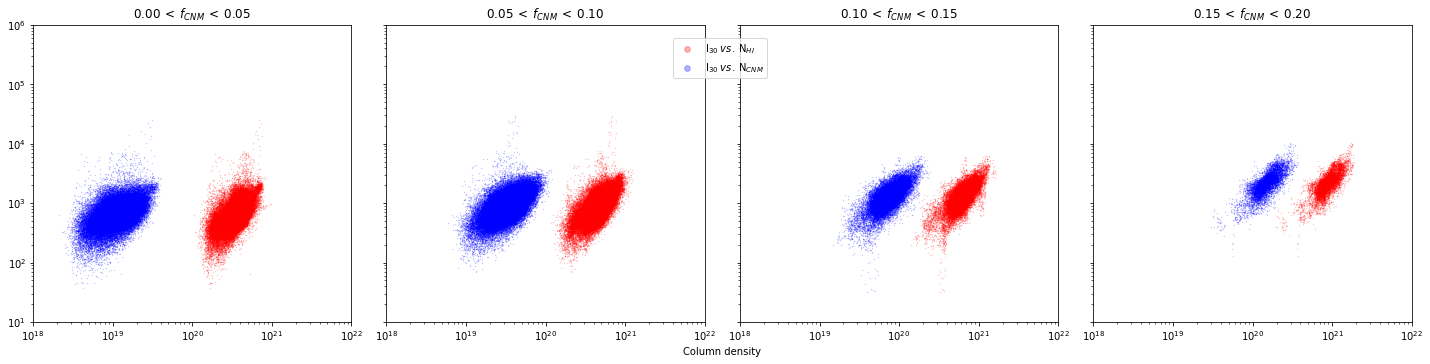

In [14]:
fig, ax = plt.subplots(1,4, sharey='row', figsize=(20,5))

a = ax[0].scatter(NH_bin0, I_bin0, s=.1, alpha=.3, c='r')
z = ax[0].scatter(NCNM_bin0, I_bin0, s=.1, alpha=.3, c='b')
ax[0].set_xlim(1e18, 1e22)
ax[0].set_ylim(10, 1e6)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title(r'$0.00\: <\: f_{CNM}\: <\: 0.05$')

b = ax[1].scatter(NH_bin1, I_bin1, s=.1, alpha=.3, c='r')
ax[1].scatter(NCNM_bin1, I_bin1, s=.1, alpha=.3, c='b')
ax[1].set_xlim(1e18, 1e22)
ax[1].set_ylim(10, 1e6)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title(r'$0.05 \:< \:f_{CNM}\: < \:0.10$')

c = ax[2].scatter(NH_bin2, I_bin2, s=.1, alpha=.3, c='r')
ax[2].scatter(NCNM_bin2, I_bin2, s=.1, alpha=.3, c='b')
ax[2].set_xlim(1e18, 1e22)
ax[2].set_ylim(10, 1e6)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title(r'$0.10\: <\: f_{CNM}\: <\: 0.15$')

d = ax[3].scatter(NH_bin3, I_bin3, s=.1, alpha=.3, c='r')
ax[3].scatter(NCNM_bin3, I_bin3, s=.1, alpha=.3, c='b')
ax[3].set_xlim(1e18, 1e22)
ax[3].set_ylim(10, 1e6)
ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_title(r'$0.15\: < \:f_{CNM}\: <\: 0.20$')

fig.text(0.505, 0, 'Column density', ha='center')
plt.figlegend((a,z), (r'$\mathrm{I}_{30}\; vs.\: \mathrm{N}_{HI}$', r'$\mathrm{I}_{30}\; vs.\: \mathrm{N}_{CNM}$'), 
              loc='upper center', bbox_to_anchor=(.5,.92), markerscale=18)
fig.tight_layout(pad=1.2)

/home/mdodici/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


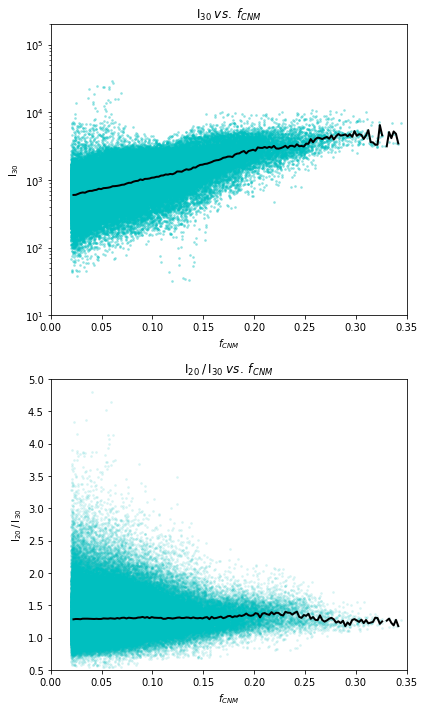

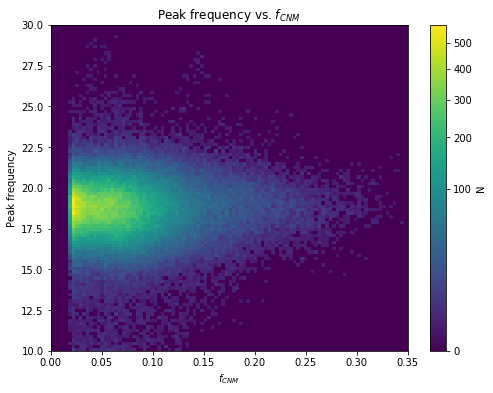

In [15]:
fig1, ax1 = plt.subplots(2,1, figsize=(6,10))
fCNM_short = fCNM[idx]
ratio_short = (I20/I30)[idx]
ratio_meds, ratio_edges, ratio_num = stats.binned_statistic(fCNM_short, ratio_short, statistic='median', bins=150, range=[0.02, .36])
meds30, edges30, num30 = stats.binned_statistic(fCNM, I30, statistic='median', bins=150, range=[0.02, .36])

ax1[0].scatter(fCNM, I30, s=3, alpha=.3, c='c')
ax1[0].plot(edges30[1:], meds30, 'k', lw=2)
ax1[0].set_xlim(0, 0.35)
ax1[0].set_ylim(10, 2e5)
ax1[0].set_xlabel(r'$f_{CNM}$')
ax1[0].set_ylabel(r'$\mathrm{I}_{30}$')
ax1[0].set_yscale('log')
ax1[0].set_title(r'$\mathrm{I}_{30}\; vs.\: f_{CNM}$')

ax1[1].scatter(fCNM_short, ratio_short, s=3, alpha=.1, c='c')
ax1[1].plot(ratio_edges[1:], ratio_meds, 'k', lw=2)
ax1[1].set_ylim(0.5,5)
ax1[1].set_xlim(0, .35)
ax1[1].set_xlabel(r'$f_{CNM}$')
ax1[1].set_ylabel(r'$\mathrm{I}_{20}\:/\:\mathrm{I}_{30}$')
#ax1[1].set_yscale('log')
ax1[1].set_title(r'$\mathrm{I}_{20}\:/\:\mathrm{I}_{30}\; vs.\: f_{CNM}$')

fig1.tight_layout()
fig1.savefig('I3_I2-I3_fCNM.png')

fig2, ax2 = plt.subplots(figsize=(8,6))
g = ax2.hist2d(fCNM, nup1, bins=100, range=[[0, .35], [10, 30]], norm=colors.PowerNorm(.4))
ax2.set_ylabel('Peak frequency')
ax2.set_title('Peak frequency vs. ' + r'$f_{CNM}$')
ax2.set_xlabel(r'$f_{CNM}$')
cbar2 = fig2.colorbar(g[3])
cbar2.set_label('N')

In [19]:
#ratio of I(20) from AME to I(545) from thermal dust for various pixels plotted against f_CNM
fCNM_short = fCNM[idx]
I_normto = I_therm(Ad, Bd, Td, 545)

peak_var = 20
I_variable = I(a1, a2, nup1, nu_sd, f, peak_var)

y = np.divide(I_variable, N_HI)
y2 = np.divide(I_normto, N_HI)

y_short = y[idx]
y2_short = y2[idx]

numbins = 150
y_meds, y_edges, y_num  = stats.binned_statistic(fCNM_short, y_short, statistic='median', bins=numbins, range=[0.02, .36])
y2_meds, y2_edges, y2_num  = stats.binned_statistic(fCNM_short, y2_short, statistic='median', bins=numbins, range=[0.02, .36])

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


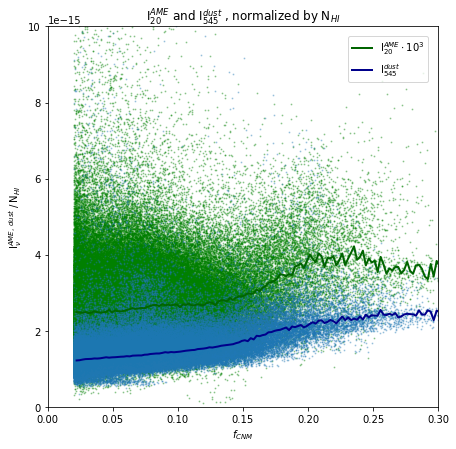

In [25]:
fign, axn = plt.subplots(figsize=(7,7))

axn.scatter(fCNM_short, y_short*1000, s=1, alpha=.3, c='g')
axn.scatter(fCNM_short, y2_short, s=1, alpha=.3)
axn.plot(y2_edges[1:], y2_meds, '#00008B', lw=2)
axn.plot(y_edges[1:], y_meds*1000, '#006400', lw=2)
axn.set_xlim(0, .30)
axn.set_ylim(0,1e-14)
axn.set_ylabel(r'$\mathrm{I}^{AME,\:dust}_{\nu}\:/\:\mathrm{N}_{HI}$')
axn.set_xlabel(r'$f_{CNM}$')
axn.set_title(r'$\mathrm{I}^{AME}_{20}$'+' and '+r'$\mathrm{I}^{dust}_{545}\;$'+', normalized by '+r'$\mathrm{N}_{HI}$')

green = Line2D([0], [0], color='#006400', linewidth=2)
blue = Line2D([0], [0], color='#00008B', linewidth=2)
plt.figlegend(handles=[green, blue], labels=[r'$\mathrm{I}^{AME}_{20}\cdot10^3$', r'$\mathrm{I}^{dust}_{545}$'], 
              loc='upper right', bbox_to_anchor=(0.86, 0.83))

ZeroDivisionError: division by zero

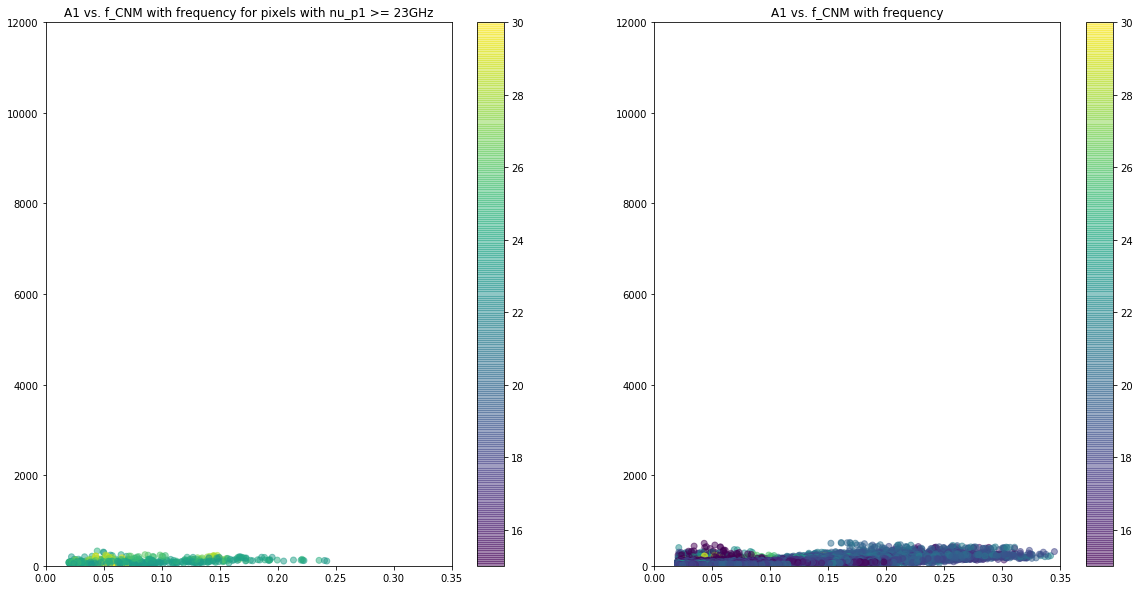

In [26]:
# Makes two scatter plots displaying A1 vs. fCNM for a number of pixels.
# First plot shows only those pixels with a peak frequency above a certain cutoff (lim) while second plot shows all pixels. 
# 
# Also prints four percentages: 
#    high frequency pixels out of high amplitude pixels
#    high frequency pixels out of low amplitude pixels 
#    high amplitude pixels out of high frequency pixels
#    high amplitude pixels out of all pixels

lim = 23
a1_hi = []
fCNM_hi = []
nup1_hi = []
for x in range(len(fCNM)):
    if nup1[x] >= lim:
        a1_hi.append(a1[x])
        fCNM_hi.append(fCNM[x])
        nup1_hi.append(nup1[x])

hia_hinup = sum(1 if a1[i] >= 750 and nup1[i] >= lim else 0 for i in range(len(a1)))#number of points at high a1 with nup1 above limit
loa_hinup = sum(1 if a1[i] < 750 and nup1[i] >= lim else 0 for i in range(len(a1))) #number of points at low a1 with nup1 above limit
hia = sum(1 if a1[i] >= 750 else 0 for i in range(len(a1)))
loa = sum(1 if a1[i] < 750 else 0 for i in range(len(a1)))

fig, ax = plt.subplots(1,2, figsize=(20,10))

#plots points of nu_p1 greater than a certain limit
a = ax[0].scatter(fCNM_hi, a1_hi, alpha=.5, c=nup1_hi, vmin=15, vmax=30)
ax[0].set_ylim(0,12000)
ax[0].set_xlim(0,.35)
ax[0].set_title('A1 vs. f_CNM with frequency for pixels with nu_p1 >= ' + str(lim) + 'GHz')
fig.colorbar(a, ax=ax[0])

#plots all 100000 points
b = ax[1].scatter(fCNM, a1, alpha=.5, c=nup1, vmin=15, vmax=30)
ax[1].set_ylim(0,12000)
ax[1].set_xlim(0,.35)
ax[1].set_title('A1 vs. f_CNM with frequency')
fig.colorbar(b, ax=ax[1])

print(100*hia_hinup/hia) #Percent of high A1 vals with hi nup1: 
print(100*loa_hinup/loa) #Percent of low A1 vals with hi nup1:
print(100*hia_hinup/(hia_hinup+loa_hinup)) #Percent of hi nup1 pixels with hi A1:
print(100*hia/(hia+loa)) #Percent of pixels with hi A1:

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


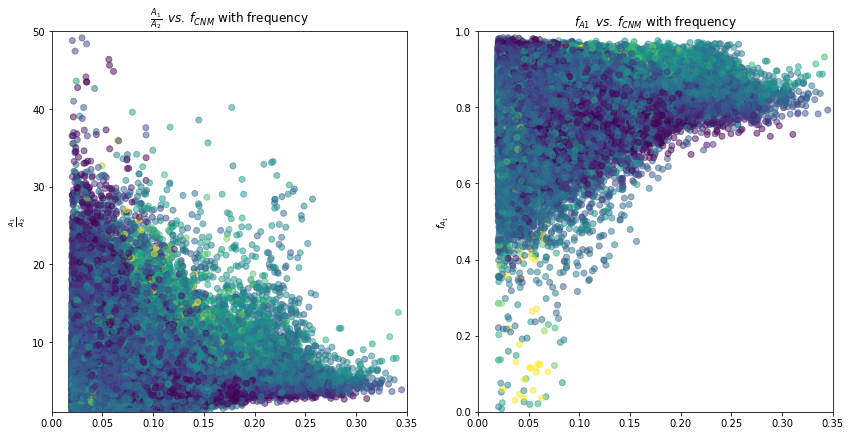

In [27]:
r = a1/a2
fa1 = a1/(a1+a2)

figr, axr = plt.subplots(1,2, figsize=(14,7), sharex=True)

#plots ratio of two amplitued vs. f_CNM
a = axr[0].scatter(fCNM, r, alpha=.5, c=nup1, vmin=16, vmax=25)
axr[0].set_ylim(1,50)
axr[0].set_xlim(0, .35)
axr[0].set_ylabel(r'$\frac{A_1}{A_2}$')
axr[0].set_title(r'$\frac{A_1}{A_2}\;\: vs.\: f_{CNM}$' + ' with frequency')
figr.colorbar(a, ax=ax[0])

#plots fraction of total amplitude included in primary map vs. f_CNM
b = axr[1].scatter(fCNM, fa1, alpha=.5, c=nup1, vmin=16, vmax=25)
axr[1].set_ylim(0,1)
axr[1].set_xlim(0,.35)
axr[1].set_ylabel(r'$f_{A_{1}}$')
axr[1].set_title(r'$f_{A1}\;\: vs.\: f_{CNM}$' + ' with frequency')
figr.colorbar(b, ax=ax[1])

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


Pixel 0
358384 b
f_CNM: nan
A1: 0.0
A2: 0.0
nu_p1: 0.0
Pixel 1
345140 r
f_CNM: nan
A1: 0.0
A2: 0.0
nu_p1: 0.0


/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


Pixel 2
376966 g
f_CNM: nan
A1: 0.0
A2: 0.0
nu_p1: 0.0
Pixel 3
343783 c
f_CNM: nan
A1: 0.0
A2: 0.0
nu_p1: 0.0


/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

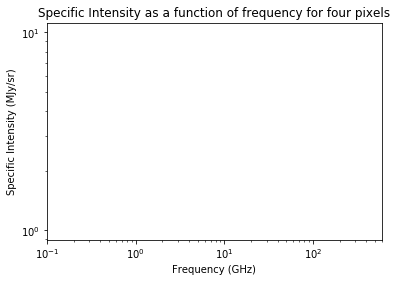

In [30]:
# This cell plots four random pixels and prints
# their f_CNM values in an attempt to see if there 
# is any relation between the two.

pix = []
for i in range(4):
    x = random.randint(330000, 400000)
    pix.append(x)

b = len(pix) #number of pixels to be plotted
nu = np.linspace(.1, 1000, len(a1)) #creates a range of values nu

for i in range(b):
    a1_i = a1[i] #sets A1 for the ith random pixel
    a2_i = a2[i] #sets A2 for the ith random pixel
    nup1_i = nup1[i] #sets nu_p1 for the ith random pixel
    
    I_nui = I(a1_i, a2_i, nup1_i, nu_sd, f, nu) #sets I_nu(nu) for the ith random pixel
    
    color = ['b', 'r', 'g', 'c', 'm', 'y', 'k'] #creates an array of four different color possibilities
    print('Pixel ' + str(i))
    print(pix[i], color[i])
    
    plt.plot(nu, I_nui, color[i]) #plots I_nu(nu) for each pixel, each in a different color
    print('f_CNM: ' + str(fCNM[pix[i]]*100))
    print('A1: ' + str(a1_i))
    print('A2: ' + str(a2_i))
    print('nu_p1: ' + str(nup1_i))

plt.yscale('log')
plt.xscale('log')
plt.xlim(.1,600)
plt.title('Specific Intensity as a function of frequency for four pixels')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')

In [ ]:
#Compares specific intensity curves for random points with low f_CNM to random points with high f_CNM

idx = np.random.choice(np.arange(len(f_CNM)), 300000, replace=False)

m_hi, m_lo = [], []
n_hi, n_lo = [], []
nu_p_hi, nu_p_lo = [], []
f_CNM_hi, f_CNM_lo = [], []

for i in idx:                        #creates bins of high and low f_CNM pixels, fills empty lists with their parameters 
    if 0 < f_CNM[i] < 0.02:
        m_lo.append(m[i])
        n_lo.append(n[i])
        nu_p_lo.append(nu_p[i])
        f_CNM_lo.append(f_CNM[i])
    elif 0.29 < f_CNM[i] < 0.31:
        m_hi.append(m[i])
        n_hi.append(n[i])
        nu_p_hi.append(nu_p[i])
        f_CNM_hi.append(f_CNM[i])

pix_lo = []
pix_hi = []
for i in range(2):                    #selects four random pixels, two each from high and low bins
    x = random.randint(0, len(m_lo))
    pix_lo.append(x-1)
    y = random.randint(0, len(m_hi))
    pix_hi.append(y-1)
    
b = len(pix_lo)                       #number of pixels to be plotted
nu = np.linspace(.1, 1000, len(m_lo)) #creates a range of values nu

for i in range(b):
    a1_lo = m_lo[pix_lo[i]] 
    a2_lo = n_lo[pix_lo[i]] 
    nup1_lo = nu_p_lo[pix_lo[i]] 
    I_nulo = I(a1_lo, a2_lo, nup1_lo, nu_sd, f, nu) 
    I_30lo = I(a1_lo, a2_lo, nup1_lo, nu_sd, f, 30)
    
    a1_hi = m_hi[pix_hi[i]] 
    a2_hi = n_hi[pix_hi[i]] 
    nup1_hi = nu_p_hi[pix_hi[i]]
    I_nuhi = I(a1_hi, a2_hi, nup1_hi, nu_sd, f, nu)
    I_30hi = I(a1_hi, a2_hi, nup1_hi, nu_sd, f, 30)
    
    plt.plot(nu, I_nuhi/I_30hi, 'r')
    plt.plot(nu, I_nulo/I_30lo, 'b')

    #print('f_CNM: ' + str(f_CNM_hi[pix_hi[i]]*100))
    #print('f_CNM: ' + str(f_CNM_lo[pix_lo[i]]*100))

    plt.xlim(.1,60)
    plt.title('Specific Intensity as a function of frequency for four pixels')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Specific Intensity (MJy/sr)')

print("Red is high, Blue is low")

In [ ]:
def I_bins(m, n, nu_p, nu):
    '''Calculates median and std curves of specific intensity vs. frequency for a given bin
    
    Input:  m: array, map of primary component
            n: array, map of secondary component
            nu_p: array, map of peak frequency for primary component
           
    Return: I_norm: array representing normalized median specific intensity
            std: array, standard deviation
            nu: array, frequency values for pixels involved'''
    b = np.array(range(len(m)))
    
    I_normed = np.empty((1,100))
    for i in b:
        a1 = m[i]
        a2 = n[i]
        nup = nu_p[i]
        
        Ii = np.array(I(a1, a2, nup, nu_sd, f, nu))
        I30 = np.array(I(a1, a2, nup, nu_sd, f, 30))

        Ii_norm = Ii/I30
        I_normed = np.vstack((I_normed, Ii_norm)) #makes ix100 array showing I; each row is one of n pixels, columns are distinct values of nu 
    
    I_median = np.median(I_normed, axis=0) #takes median of the columns of our array representing I    
    std = np.std(I_normed, axis=0)
    
    return I_median, std*(1/2)

In [ ]:
#Implements the function above to graph median SED curves for four bins of various f_CNM

idx = np.random.choice(np.arange(len(f_CNM)), 10000, replace=False) #picks a set of pixels from the length of f_CNM

m_0, m_1, m_2, m_3, m_4, m_5 = ([] for i in range(6)) #creates 6 empty bins for m
n_0, n_1, n_2, n_3, n_4, n_5 = ([] for i in range(6)) #creates 6 empty bins for n
nu_p0, nu_p1, nu_p2, nu_p3, nu_p4, nu_p5 = ([] for i in range(6)) #creates 6 empty bins for nu_p
f_CNM0, f_CNM1, f_CNM2, f_CNM3, f_CNM4, f_CNM5 = ([] for i in range(6)) #creates 6 empty bins for f_CNM
    
for x in idx: #sorts the pixels into bins based on fCNM
    if 0 < f_CNM[x] <= 0.08:
        m_0.append(m[x])
        n_0.append(n[x])
        nu_p0.append(nu_p[x])
    elif 0.08 < f_CNM[x] <= 0.16:
        m_1.append(m[x])
        n_1.append(n[x])
        nu_p1.append(nu_p[x])
    elif 0.16 < f_CNM[x] <= 0.24:
        m_2.append(m[x])
        n_2.append(n[x])
        nu_p2.append(nu_p[x])
    elif 0.24 < f_CNM[x] <= 0.32:
        m_3.append(m[x])
        n_3.append(n[x])
        nu_p3.append(nu_p[x])

print(len(m_0))
print(len(m_1))
print(len(m_2))
print(len(m_3))

nu = np.linspace(1, 100, 100)

I0, std0 = I_bins(m_0, n_0, nu_p0, nu)
pos0 = I0 + std0
neg0 = I0 - std0
I1, std1 = I_bins(m_1, n_1, nu_p1, nu)
pos1 = I1 + std1
neg1 = I1 - std1
I2, std2 = I_bins(m_2, n_2, nu_p2, nu)
pos2 = I2 + std2
neg2 = I2 - std2
I3, std3 = I_bins(m_3, n_3, nu_p3, nu)
pos3 = I3 + std3
neg3 = I3 - std3

plt.plot(nu, I0, 'r')
plt.fill_between(nu, pos0, neg0, color='r', alpha = .2)
plt.plot(nu, I1, 'b')
plt.fill_between(nu, pos1, neg1, color='b', alpha = .2)
plt.plot(nu, I2, 'c')
plt.fill_between(nu, pos2, neg2, color='c', alpha = .2)
plt.plot(nu, I3, 'g')
plt.fill_between(nu, pos3, neg3, color='g', alpha = .2)

plt.xlim(1,40)
plt.ylim(0.5,1.7)
plt.title('Median Specific Intensity as a function of frequency for four f_CNM bins')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')